<html>
   <head>
      <title>Customer Life Time Value</title>
   </head>
   <body>
      <h1><font size="5">Part 4: Customer Lifetime Value</font></h1>
      <ul style="list-style-type:none;line-height: 2;">
         <li><font size="3"><a href='#1'>1. Clustering of User Data</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#1.1'>1.1 Preparation for Kmeans</a></font></li>
             <li><font size="3"><a href='#1.2'>1.2 Elbow Method</a></font></li>
             <li><font size="3"><a href='#1.3'>1.3 Score Function</a></font></li>
             <li><font size="3"><a href='#1.4'>1.4 Clustering and Evalutation</a></font></li>
                 <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
                 <li><font size="3"><a href='#1.4.1'>1.4.1 Unscaled</a></font></li>
                 <li><font size="3"><a href='#1.4.2'>1.4.2 Standard Scaled</a></font></li>
                 <li><font size="3"><a href='#1.4.3'>1.4.3 MinMax Scaled</a></font></li>
                 </ul> 
             </ul>          
         <li><font size="3"><a href='#2'>2. Segmenting Customers by RFM</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#2.1'>2.1 Recency</a></font></li>
             <li><font size="3"><a href='#2.2'>2.2 Frequency</a></font></li>
             <li><font size="3"><a href='#2.3'>2.3 Monetary Value</a></font></li>
             <li><font size="3"><a href='#2.4'>2.4 Overall User Score</a></font></li>
             </ul>          
      </ul>
   </body>
</html>

In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture

In [5]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

## Loading Dataframes

In [6]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_userscr = pd.read_pickle("./Data/users_with_score.pickle")

In [4]:
df.date.min()

Timestamp('2017-11-01 00:00:00')

In [5]:
df.date.max()

Timestamp('2019-02-28 00:00:00')

In [13]:
df_userscr.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low
1,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low
2,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low
3,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low
4,6,25.20,1,0,0,0,25.200,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Meinerzhagen,mobile,Chrome,Android,Germany,0,71,1,2,low


## Lifetime Value Calculation by hand

### Calculate rates assuming constants

In [6]:
#overall purchase frequency
purchase_frequency = sum(df_userscr['total_purchases']) / df_userscr.shape[0]

In [7]:
#overall repetition rate
repeat_rate = df_userscr[df_userscr.total_purchases > 1].shape[0] / df_userscr.shape[0]

In [8]:
#churn rate
churn_rate = 1 - repeat_rate

In [9]:
purchase_frequency,repeat_rate,churn_rate

(1.3411856727329963, 0.17860578814905473, 0.8213942118509453)

### Customer Lifetime Value Variable

In [ ]:
df_constant_ltv = df_userscr.copy()

In [14]:
#customer value
df_constant_ltv['c_value'] = round((df_constant_ltv['avg_shop_cart'] * purchase_frequency) / churn_rate, 2)

In [15]:
#profit variable, here arbitrarily assume that 6% of sales is profit
df_constant_ltv['profit_margin'] = df_constant_ltv['revenue'] * 0.06

In [19]:
#lifetime value
df_constant_ltv['cust_lifetime_value'] = (df_constant_ltv['c_value'] * df_constant_ltv['profit_margin']).round(2)

In [20]:
df_constant_ltv.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,c_value,profit_margin,cust_lifetime_value
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany,0,216,2,1,low,120.02,8.8206,1058.65
1,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany,0,339,1,0,low,137.34,5.0466,693.10
2,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany,0,42,1,2,low,101.76,3.7392,380.50
3,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany,0,185,2,1,low,73.39,5.3934,395.82
4,6,25.20,1,0,0,0,25.200,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,North Rhine-Westphalia,Meinerzhagen,mobile,Chrome,Android,Germany,0,71,1,2,low,41.15,1.5120,62.22


In [7]:
df.head()

,visit_id,user_id,visit_number,date,day_of_week,article_name,article_id,price,quantity,total_price,shop_cart_value,shop_cart_item_count,shop_cart_unique_articles,country,region,city,city_id,women_article,men_article,kids_article,homeandliving_article,campaign_involved,category,category_slim,brand,product_line,product_group,genre_column_placeholder,device_category,device_browser,device_os,stock_value,year_month,min_purchase_date,user_type
0,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
1,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
2,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
3,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
4,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 50 EUR,200000000050,50.0,1,50.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 50 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first


## Lifetime Value Prediction

In [32]:
df_pred_ltv = df_userscr.copy()

In [3]:
#Here I will use the Lifetimes package which finds
#frequent use in predicting lifetime value of customers
from lifetimes.utils import summary_data_from_transaction_data

In [8]:
data = summary_data_from_transaction_data(df.drop_duplicates(subset ="visit_id"),
                                          'user_id',
                                          'date', 
                                          monetary_value_col='total_price',
                                          observation_period_end = df["date"].max())
data.head()

,frequency,recency,T,monetary_value
user_id,,,,
1,1.0,19.0,235.0,15.96
2,0.0,0.0,454.0,0.00
3,0.0,0.0,339.0,0.00
4,0.0,0.0,42.0,0.00
5,1.0,21.0,206.0,26.88


In [9]:
from lifetimes import BetaGeoFitter
 
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 622617 subjects, a: 1.27, alpha: 13.28, b: 1.24, r: 0.07>

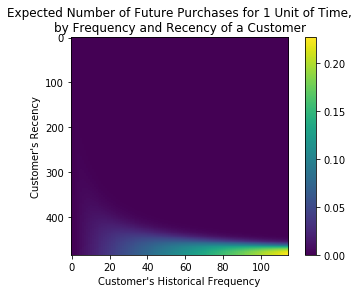

In [13]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

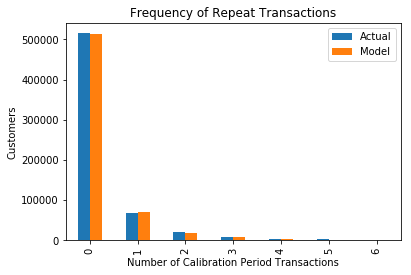

In [14]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [24]:
future_horizon = 365
data['predicted_purchases'] = bgf.predict(future_horizon,
                                          data['frequency'],
                                          data['recency'],
                                          data['T'])
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
1,1.0,19.0,235.0,15.96,0.105631
2,0.0,0.0,454.0,0.00,0.045886
3,0.0,0.0,339.0,0.00,0.058171
4,0.0,0.0,42.0,0.00,0.214214
5,1.0,21.0,206.0,26.88,0.137319


In [25]:
data["status_alive"] = bgf.conditional_probability_alive(data['frequency'],
                                                         data['recency'],
                                                         data['T'])

In [26]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases,status_alive
user_id,,,,,,
1,1.0,19.0,235.0,15.96,0.105631,0.099336
2,0.0,0.0,454.0,0.00,0.045886,1.000000
3,0.0,0.0,339.0,0.00,0.058171,1.000000
4,0.0,0.0,42.0,0.00,0.214214,1.000000
5,1.0,21.0,206.0,26.88,0.137319,0.118424


Note that customers who have only one purchase get a status prediction of one hence to the model. So we have to ignore values of one in further use of this.

In [28]:
#as the method that is beeing used below requires monetary values greater than zero
#a arbitrarily small enough amount will be added to the zeroes 
def addfk(number):
    return number + 0.01 if number == 0 else number

In [30]:
from lifetimes import GammaGammaFitter
data["monetary_value_plchldr"] = data["monetary_value"].apply(addfk)
returning_customers_summary = data[data['frequency'] > 0]
 
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value_plchldr'])

transaction_spend = ggf.conditional_expected_average_profit(data['frequency'],
                                                            data['monetary_value']).mean()
print(transaction_spend)

30.234878076872228


In [34]:
df_pred_ltv = df_pred_ltv.join(data["predicted_purchases"], on = "user_id", how = "left")
 
df_pred_ltv["clv"] = df_pred_ltv.apply(lambda x: x["predicted_purchases"] * transaction_spend, axis = 1)

In [38]:
df_pred_ltv["predicted_purchases"] = df_pred_ltv["predicted_purchases"].round(2)

In [40]:
df_pred_ltv["clv"] = df_pred_ltv["clv"].round(2)

In [27]:
sale = df.drop_duplicates(subset ="visit_id").pivot_table(index=['user_id'],columns=['year_month'],values='shop_cart_value',aggfunc='sum',fill_value=0).reset_index()

In [31]:
sale['clv']=sale.iloc[:,2:].sum(axis=1)

In [32]:
sale.head()

year_month,user_id,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,clv
0,1,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,147.01,0.00,0.0,0.0,0.0,0.0,0.00,0.0,147.01
1,2,0.0,208.34,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,208.34
2,3,0.0,0.00,0.0,0.0,84.11,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,84.11
3,4,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,62.32,0.0,62.32
4,5,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,89.89,0.0,0.0,0.0,0.0,0.00,0.0,89.89
